<img src = https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png width = 200>
<h1 align=center> Hierarchical Clustering in Python </h1>

<hr>

### Using this notebook:

**Shift + Enter** to run a cell:

# Weather Station Clustering 

## Hierarchical Clustering using python & scikit-learn¶

Lets import all the libraries that we need.

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
import pylab
import scipy
import scipy.cluster.hierarchy as sch
%matplotlib inline


### About the dataset

Environment Canada		  
Monthly Values for June - 2015	  	
		
Legend  		
Stn_Name::::	Station Name  
Lat	    ::::	Latitude (North + , degrees)  
Long	::::	Longitude (West - , degrees)  
Prov	::::	Province  
Tm	    ::::	Mean Temperature (Â°C)  
DwTm	::::	Days without Valid Mean Temperature  
D	    ::::	Mean Temperature difference from Normal (1981-2010) (Â°C)  
Tx	    ::::	Highest Monthly Maximum Temperature (Â°C)  
DwTx	::::	Days without Valid Maximum Temperature  
Tn	    ::::	Lowest Monthly Minimum Temperature (Â°C)  
DwTn	::::	Days without Valid Minimum Temperature  
S	    ::::	Snowfall (cm)  
DwS	    ::::	Days without Valid Snowfall  
S%N	    ::::	Percent of Normal (1981-2010) Snowfall  
P	    ::::	Total Precipitation (mm)  
DwP	    ::::	Days without Valid Precipitation  
P%N	    ::::	Percent of Normal (1981-2010) Precipitation  
S_G  	::::	Snow on the ground at the end of the month (cm)  
Pd	    ::::	Number of days with Precipitation 1.0 mm or more  
BS	    ::::	Bright Sunshine (hours)  
DwBS	::::	Days without Valid Bright Sunshine  
BS%  	::::	Percent of Normal (1981-2010) Bright Sunshine  
HDD 	::::	Degree Days below 18 Â°C  
CDD	    ::::	Degree Days above 18 Â°C  
Stn_No	::::	Climate station identifier (first 3 digits indicate   drainage basin, last 4 characters are for sorting alphabetically).  
NA	    ::::	Not Available  

### 1-Download data into your Data Scientist Workbench

In [2]:
!wget -O weather-stations20140101-20141231.csv https://ibm.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv

--2017-09-15 10:14:25--  https://ibm.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv [following]
--2017-09-15 10:14:26--  https://ibm.ent.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.24.211, 107.152.25.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.24.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/jZ3RfFn1Ith-0tFX0z0ofZOGmscRFrUyJAQjyeEGvK1YtLY7e00I9ReIhz1s-zm4mzZi2tbXwUu6cquR1BB23N05PMtUI_4Dfr2cPPdUKDOW6i-2ezIWZkZTImnJ0d5jKgc_oIHoRHgMfXpeqNI6Dt6msEaPqTaHdW49ZgmjRODbB5m1feeY52OKkffhsCgyg1z9AF4NcYeh71rwHSgOn-rwfCM6LQLrzEyw0GqAECHrnMNsy1J-baXl5KbaB8oLGY1uIEGzy

### 2- Load the dataset

In [3]:
filename='weather-stations20140101-20141231.csv'

#Read csv
pdf = pd.read_csv(filename)
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0,NaN,13.5,0,1.0,...,0,NaN,0,12,NaN,NaN,NaN,273.3,0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0,3.0,15.0,0,-3.0,...,0,104,0,12,NaN,NaN,NaN,307.0,0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13,2.8,16.0,9,-2.5,...,9,NaN,NaN,11,NaN,NaN,NaN,168.1,0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2,3.4,14.5,2,-1.0,...,2,NaN,NaN,11,NaN,NaN,NaN,267.7,0,1012573


In [4]:
pdf.size

33525

### 3- Data Cleaning

In [31]:
pdf = pdf[pd.notnull(pdf["Tm"]) & np.isfinite(pdf['Tm'])]
pdf = pdf.reset_index(drop=True)
print(pdf.size)
pdf.head(10)

32103


,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No,xm,ym
0,CHEMAINUS,48.935,-123.742,BC,8.2,0,NaN,13.5,0,1.0,...,0,12,NaN,NaN,NaN,273.3,0,1011500,1807806.266120,1396332.287866
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0,3.0,15.0,0,-3.0,...,0,12,NaN,NaN,NaN,307.0,0,1012040,1764329.070275,1377564.348686
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13,2.8,16.0,9,-2.5,...,NaN,11,NaN,NaN,NaN,168.1,0,1012055,1773335.855092,1378408.856386
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2,3.4,14.5,2,-1.0,...,NaN,11,NaN,NaN,NaN,267.7,0,1012573,1809362.994360,1362546.186690
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0,NaN,13.1,0,1.9,...,NaN,12,NaN,NaN,NaN,258.6,0,1012710,1841498.313029,1311615.319829
5,GALIANO NORTH,48.985,-123.573,BC,8.9,7,NaN,13.5,7,2.0,...,0,10,NaN,NaN,NaN,191.7,0,10130MN,1826598.199874,1404799.946976
6,MALAHAT,48.575,-123.530,BC,7.2,1,NaN,12.7,1,2.2,...,NaN,12,NaN,NaN,NaN,290.8,0,1014820,1831379.579469,1335613.959372
7,NORTH COWICHAN,48.824,-123.719,BC,7.7,0,NaN,14.7,0,-2.6,...,0,12,NaN,NaN,NaN,288.8,0,1015630,1810363.748229,1377564.348686
8,NORTH PENDER ISLAND,48.764,-123.287,BC,8.6,1,NaN,14.0,1,2.0,...,0,13,NaN,NaN,NaN,253.6,0,1015638,1858399.933920,1367436.821190
9,RACE ROCKS,48.298,-123.531,BC,9.6,0,NaN,15.6,0,5.2,...,NaN,NaN,NaN,NaN,NaN,234.7,0,1016640,1831268.384594,1289188.304759


### 4- Data Visualization

/usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


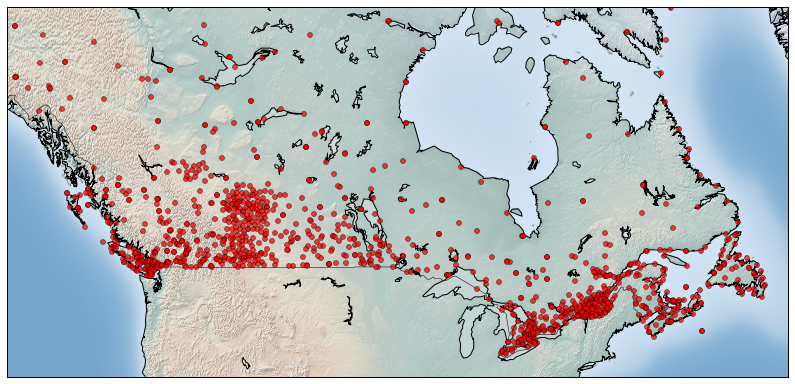

In [8]:
rcParams['figure.figsize'] = (14,10)

llon = -140
ulon = -50
llat = 40
ulat = 65

pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf['xm'] = xs.tolist()
pdf['ym'] = ys.tolist()

#Visualization1
for index,row in pdf.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()



### 5- Data Sampling

In [33]:
hpdf = pdf.sample(frac=0.03, replace=False).reset_index(drop=True)
print hpdf.shape
hpdf.head()

(36, 27)


,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No,xm,ym
0,EGG ISLAND,51.247,-127.835,BC,7.3,0,2.2,13.0,0,1.0,...,0,17,NaN,NaN,NaN,299.4,0,1062646,1352685.645673,1797145.664038
1,ATLIN,59.567,-133.700,BC,-8.8,0,1.9,7.5,0,-31.0,...,11,4,NaN,NaN,NaN,750.6,0,1200560,700527.707993,3434168.825933
2,ST. LINA AGCM,54.282,-111.453,AB,-13.2,0,NaN,7.1,0,-28.7,...,NaN,3,NaN,NaN,NaN,872.6,0,3015673,3174280.076205,2355163.935887
3,ST COME,46.283,-73.750,QC,-18.6,6,-7.2,-3.0,4,-36.0,...,52,7,NaN,NaN,NaN,805.6,0,7017080,7366660.421360,958799.921046
4,VERNON SILVER STAR LODGE,50.359,-119.056,BC,-2.3,13,NaN,4.5,2,-10.0,...,0,10,NaN,NaN,NaN,305.2,0,1128584,2328865.447018,1640900.773995


### 6- Data Clustering using average temperature

In [37]:
#Normalization
from sklearn.preprocessing import normalize
import pylab
import scipy
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot 
%matplotlib inline
Temper = np.asarray(hpdf['Tm'])
nx = normalize(Temper.astype(float).reshape(-1, 1), axis=0)
D = scipy.zeros([nx.size,nx.size])
for i in range(nx.size):
    for j in range(nx.size):
        D[i,j] = abs(nx[i] - nx[j])
Y = sch.linkage(D, method='centroid')

/usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


### 7- Plot the first dendrogram

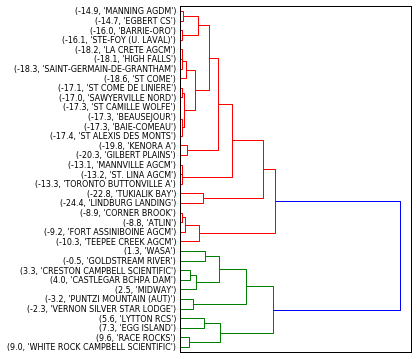

In [40]:
fig = pylab.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
Z1 = sch.dendrogram(Y, orientation='right')
ax1.set_xticks([])
lb = zip(map(lambda x: round(x,2),Temper[Z1['leaves']]),hpdf['Stn_Name'][Z1['leaves']])
ax1.set_yticklabels(lb)
fig.show()

### 8-Clustering based on location and temperature

In [41]:
#Normalization
from sklearn.preprocessing import normalize
numpyMatrix = hpdf[['Tm','Tn','Tx','xm','ym']].as_matrix()
norp = normalize(numpyMatrix, axis=0)
norp[0:5]

array([[ 0.08619357,  0.00610259,  0.26787218,  0.04227746,  0.16442112],
       [-0.10390458, -0.18918032,  0.15454164,  0.02189461,  0.31419261],
       [-0.15585687, -0.17514436,  0.14629942,  0.09921041,  0.21547429],
       [-0.21961649, -0.21969328, -0.06181666,  0.23024099,  0.08772075],
       [-0.02715688, -0.06102591,  0.09272499,  0.07278743,  0.15012625]])

In [42]:
leng = norp.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(norp[i], norp[j])

### 9-Visualization dendrogram.

/usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  app.launch_new_instance()


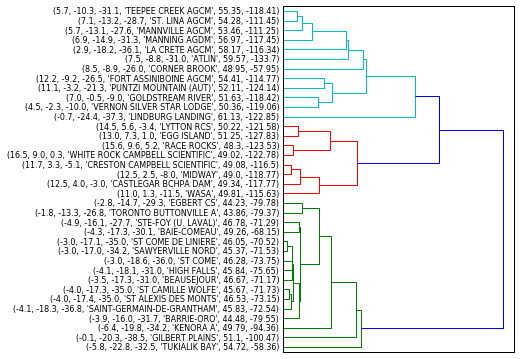

In [43]:
fig = pylab.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
Y = sch.linkage(D, method='centroid')
Z1 = sch.dendrogram(Y, orientation='right')
ax1.set_xticks([])
#ax1.set_yticks([])
lb=zip(map(lambda x: round(x,2),hpdf.Tx[Z1['leaves']]), \
       map(lambda x: round(x,2),hpdf.Tm[Z1['leaves']]), \
       map(lambda x: round(x,2),hpdf.Tn[Z1['leaves']]), \
       hpdf['Stn_Name'][Z1['leaves']],\
       map(lambda x: round(x,2),hpdf.Lat[Z1['leaves']]), \
       map(lambda x: round(x,2),hpdf.Long[Z1['leaves']]) \
      )
ax1.set_yticklabels(lb)
fig.show()

### 10- Clustering results (Labels)

In [48]:
labels = sch.fcluster(Y, 0.9*D.max(), 'distance')
hpdf["Clus_hier"]=labels-1
clusterNum=labels.max()
print (hpdf.Clus_hier)

0     1
1     3
2     3
3     0
4     2
5     1
6     0
7     2
8     2
9     0
10    0
11    1
12    0
13    1
14    1
15    0
16    1
17    3
18    2
19    1
20    0
21    0
22    0
23    0
24    4
25    1
26    0
27    3
28    0
29    3
30    3
31    0
32    0
33    3
34    0
35    0
Name: Clus_hier, dtype: int32


### 11-Visualization of clusters

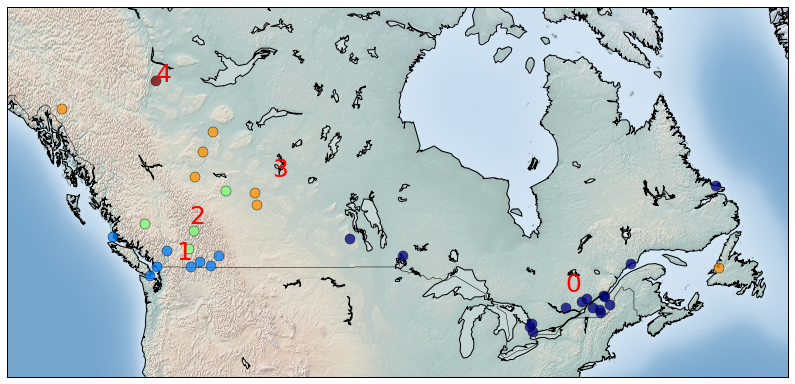

In [49]:
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

#Visualization1
for index,row in hpdf.iterrows():
    #print row.xm, row.ym , colors[np.int(row.Clus_hier)]
    my_map.plot(row.xm, row.ym, markerfacecolor =colors[np.int(row.Clus_hier)],  marker='o', markersize= 10, alpha = 0.75)
for i in range(clusterNum): 
    cluster=hpdf[["Stn_Name","Tm","xm","ym","Clus_hier"]][hpdf.Clus_hier==i]
    cenx=np.mean(cluster.xm) 
    ceny=np.mean(cluster.ym) 
    plt.text(cenx,ceny,str(i), fontsize=25, color='red',)
    #print "Cluster "+str(i)+', Avg Temp: '+ str(np.mean(cluster.Tm))

## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler for Mac users](https://cocl.us/ML0101EN_SPSSMod_mac) and [SPSS Modeler for Windows users](https://cocl.us/ML0101EN_SPSSMod_win)

Also, you can use Data Science Experience to run these notebooks faster with bigger datasets. Data Science Experience is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, DSX enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of DSX users today with a free account at [Data Science Experience](https://cocl.us/ML0101EN_DSX)

<hr>
Copyright &copy; 2016 [Big Data University](https://bigdatauniversity.com/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>